Num GPUs Available: 1
Loading MNIST dataset...

Training VAE with regularization weight: 0.001
Training VAE...
Epoch 1/10
469/469 [==============================] - 7s 9ms/step - loss: 0.2558 - val_loss: 0.2134
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2057 - val_loss: 0.2004
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1985 - val_loss: 0.1956
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1953 - val_loss: 0.1934
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 0.1932 - val_loss: 0.1920
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1917 - val_loss: 0.1909
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1905 - val_loss: 0.1900
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1897 - val_loss: 0.1903
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1890 - val_l

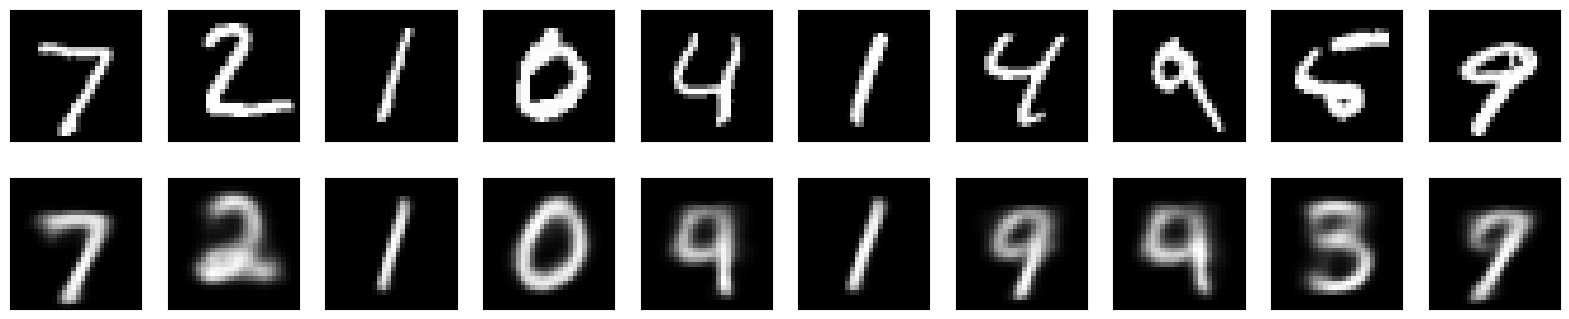


Training VAE with regularization weight: 0.01
Training VAE...
Epoch 1/10
469/469 [==============================] - 8s 10ms/step - loss: 0.2572 - val_loss: 0.2137
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2075 - val_loss: 0.2024
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2002 - val_loss: 0.1979
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1966 - val_loss: 0.1951
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1944 - val_loss: 0.1937
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1929 - val_loss: 0.1922
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1918 - val_loss: 0.1912
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1908 - val_loss: 0.1901
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1901 - val_loss: 0.1895
Epoch 10/10
469/469 [===============

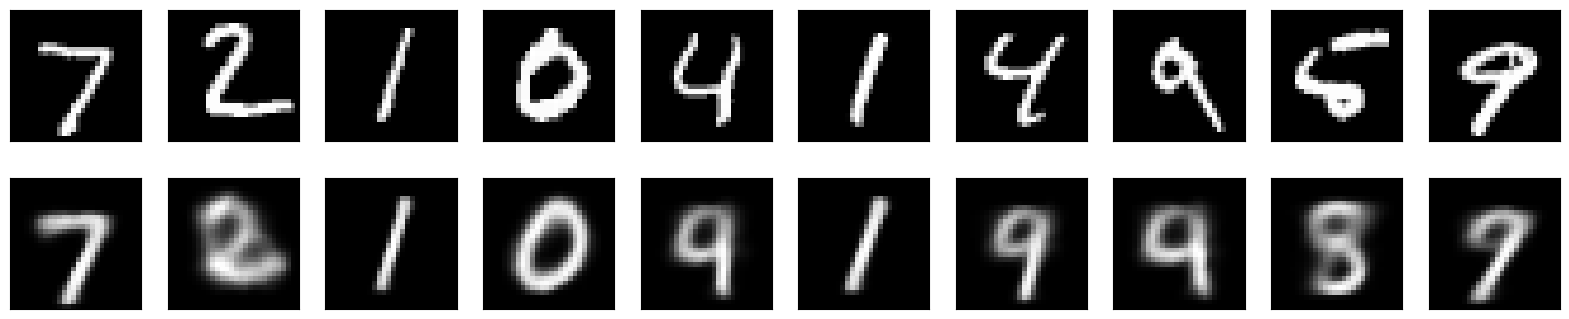


Training VAE with regularization weight: 0.1
Training VAE...
Epoch 1/10
469/469 [==============================] - 7s 10ms/step - loss: 0.2611 - val_loss: 0.2177
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2080 - val_loss: 0.2021
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1994 - val_loss: 0.1966
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1956 - val_loss: 0.1936
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1932 - val_loss: 0.1923
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1918 - val_loss: 0.1910
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1906 - val_loss: 0.1898
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1896 - val_loss: 0.1895
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 0.1888 - val_loss: 0.1888
Epoch 10/10
469/469 [================

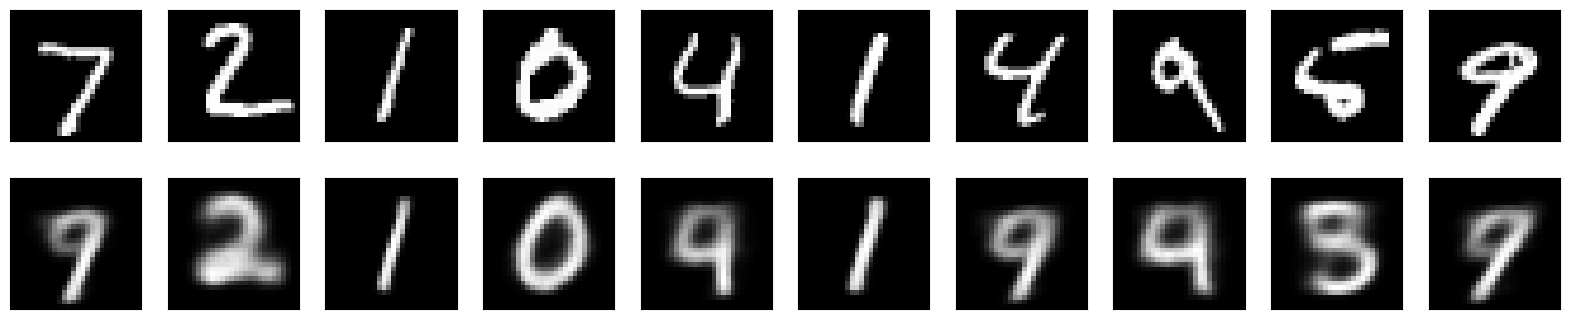

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# Check GPU availability
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape images to add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define VAE model
class VAE(keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        # Encoder network: takes input images and produces mean and log variance of latent distribution
        encoder_inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        return keras.Model(encoder_inputs, [z_mean, z_log_var])

    def build_decoder(self):
        # Decoder network: takes samples from the latent space and reconstructs images
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        return keras.Model(latent_inputs, decoder_outputs)

    def sample(self, z_mean, z_log_var):
        # Reparameterization trick: samples from a normal distribution with learned parameters
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        # Sampling from the latent space and reconstructing images
        z_mean, z_log_var = self.encoder(inputs)
        latent = self.sample(z_mean, z_log_var)
        reconstructed = self.decoder(latent)
        return reconstructed

# Define classifier model
class Classifier(keras.Model):
    def __init__(self, latent_dim, num_classes):
        super(Classifier, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.classifier = self.build_classifier()

    def build_classifier(self):
        # Classifier network: takes latent representations and predicts class probabilities
        inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(256, activation="relu")(inputs)
        x = layers.Dense(128, activation="relu")(x)
        outputs = layers.Dense(self.num_classes, activation="softmax")(x)
        return keras.Model(inputs, outputs)

    def call(self, inputs):
        return self.classifier(inputs)

# Train VAE with different regularization weights
latent_dim = 2
reg_weights = [0.001, 0.01, 0.1]
for reg_weight in reg_weights:
    print(f"\nTraining VAE with regularization weight: {reg_weight}")

    # Instantiate VAE model
    with tf.device('/GPU:0'):  # Use GPU for VAE training
        vae = VAE(latent_dim)

        # Compile VAE with binary crossentropy loss
        optimizer = keras.optimizers.Adam()
        vae.compile(optimizer, loss=keras.losses.BinaryCrossentropy())

        # Train VAE
        print("Training VAE...")
        vae.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))

        # Add regularization term to the VAE loss
        vae.add_loss(-0.5 * reg_weight * tf.reduce_mean(1 + vae.encoder.output[1] - tf.square(vae.encoder.output[0]) - tf.exp(vae.encoder.output[1])))
        vae.compile(optimizer, loss=keras.losses.BinaryCrossentropy())

        # Freeze encoder
        vae.encoder.trainable = False
        print("Encoder frozen")

    # Train classifier on top of frozen encoder
    with tf.device('/GPU:0'):  # Use GPU for classifier training
        classifier = Classifier(latent_dim, 10)
        classifier.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        print("Training classifier...")
        classifier.fit(vae.encoder.predict(x_train)[0], y_train, epochs=10, batch_size=128, validation_data=(vae.encoder.predict(x_test)[0], y_test))

    print("Classifier trained")
    # Test the trained classifier
    print("\nTesting the trained classifier...")

    # Evaluate classifier on test data
    test_loss, test_accuracy = classifier.evaluate(vae.encoder.predict(x_test)[0], y_test, verbose=0)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    import matplotlib.pyplot as plt
    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed_img = vae.predict(np.expand_dims(x_test[i], axis=0))
        plt.imshow(reconstructed_img.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()